# 3種類の小型犬の画像のCNNによる分類

In [1]:
import cv2
import glob
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Google Driveから画像データをupload & 解凍

In [4]:
!cp '/content/drive/MyDrive/Colab Notebooks/DogsClassificationTest/data.zip' .
!unzip data.zip  > files.txt

In [5]:
class_name_list = os.listdir('data')
class_name_list

['1_Shi-Tzu', '3_pug', '2_beagle']

## ファイルをread

In [6]:
# ファイルリストを取得
image_lists = []
for i in range(len(class_name_list)):
  tmp_list = glob.glob(f'./data/{class_name_list[i]}/*.jpg')
  print(f'{class_name_list[i]} : {len(tmp_list)}')
  image_lists.append(tmp_list)

1_Shi-Tzu : 214
3_pug : 200
2_beagle : 195


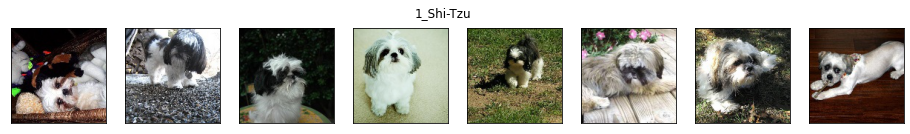

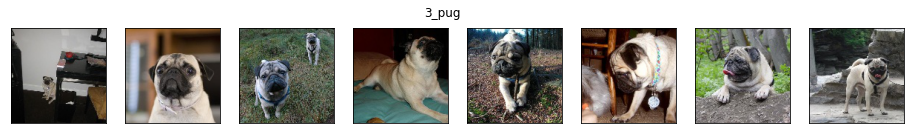

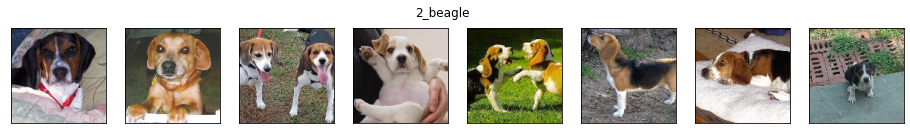

In [7]:
# 順にファイルをread，配列に格納していく
SHOW_IMAGES_NUM = 8
binded_data = []
for c_id in range(len(class_name_list)):
  tmp_data = []
  fig = plt.figure(figsize=(16, 2))
  fig.suptitle(class_name_list[c_id])
  for f_id, filepath in enumerate(image_lists[c_id]):
    img = plt.imread(filepath)
    if f_id < SHOW_IMAGES_NUM:
      ax_tmp = fig.add_subplot(1, SHOW_IMAGES_NUM, f_id + 1)
      ax_tmp.axes.xaxis.set_visible(False)
      ax_tmp.axes.yaxis.set_visible(False)
      ax_tmp.imshow(img)
    tmp_data.append(img)
  binded_data.append(tmp_data)

## 画像データをクラス内でシャッフルし、100枚を学習データ、残りをテストデータに振り分ける

In [8]:
# SEEDを設定して乱数を固定
SEED = 42

# random
random.seed(SEED)
# Numpy
np.random.seed(SEED)
# Tensorflow
tf.random.set_seed(SEED)

In [9]:
LABEL = [
  [1, 0, 0],
  [0, 1, 0],
  [0, 0, 1]
]

In [10]:
TRAIN_NUM = 100

for c_id, c_name in enumerate(class_name_list):
  data_num = len(binded_data[c_id])
  id_list = list(range(data_num))
  random.shuffle(id_list)

  train_x_tmp = np.array(binded_data[c_id])[:TRAIN_NUM]
  test_x_tmp = np.array(binded_data[c_id])[TRAIN_NUM:]
  train_y_tmp = np.array(LABEL[c_id] * TRAIN_NUM).reshape(TRAIN_NUM, len(LABEL[c_id]))
  # test_y_tmp = np.array(LABEL[c_id] * (data_num - TRAIN_NUM)).reshape((data_num - TRAIN_NUM), len(LABEL[c_id]))
  test_y_tmp = np.array([c_id] * (data_num - TRAIN_NUM))
  if c_id == 0:
    train_x = train_x_tmp
    test_x = test_x_tmp
    train_y = train_y_tmp
    test_y = test_y_tmp
  else:
    train_x = np.vstack((train_x, train_x_tmp))
    test_x = np.vstack((test_x, test_x_tmp))
    train_y = np.vstack((train_y, train_y_tmp))
    test_y = np.append(test_y, test_y_tmp)


In [11]:
# train_x, train_yをシャッフル
i_train = list(range(train_x.shape[0]))
random.shuffle(i_train)
train_x_shuffled = train_x[i_train]
train_y_shuffled = train_y[i_train]

print(f'train_x_shuffled : {train_x_shuffled.shape}')
print(f'train_y_shuffled : {train_y_shuffled.shape}')

train_x_shuffled : (300, 128, 128, 3)
train_y_shuffled : (300, 3)


#ニューラルネット（ResNet50）を構築

In [12]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNEL_NUM = 3
CLASS_NUM = 3

In [13]:
input_tensor = Input(shape=(IMAGE_HEIGHT, IMAGE_HEIGHT, CHANNEL_NUM))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#学習

In [14]:
epochs = 20
batch_size = 10
train_X = train_x_shuffled [:270]
valid_X = train_x_shuffled [270:]
train_Y = train_y_shuffled  [:270]
valid_Y = train_y_shuffled  [270:]

start_time = time.time()
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_Y))
print(f'Training Time : {time.time() - start_time}')

Epoch 1/20
27/27 [==============================] - 21s 208ms/step - loss: 1.2043 - accuracy: 0.3407 - val_loss: 1.0337 - val_accuracy: 0.5333
Epoch 2/20
27/27 [==============================] - 4s 156ms/step - loss: 0.8022 - accuracy: 0.6741 - val_loss: 0.6591 - val_accuracy: 0.7667
Epoch 3/20
27/27 [==============================] - 4s 157ms/step - loss: 0.5874 - accuracy: 0.8185 - val_loss: 0.4798 - val_accuracy: 0.8000
Epoch 4/20
27/27 [==============================] - 4s 158ms/step - loss: 0.4859 - accuracy: 0.8704 - val_loss: 0.3871 - val_accuracy: 0.9000
Epoch 5/20
27/27 [==============================] - 4s 157ms/step - loss: 0.3962 - accuracy: 0.9111 - val_loss: 0.3376 - val_accuracy: 0.9667
Epoch 6/20
27/27 [==============================] - 4s 157ms/step - loss: 0.3084 - accuracy: 0.9333 - val_loss: 0.3451 - val_accuracy: 0.9333
Epoch 7/20
27/27 [==============================] - 4s 156ms/step - loss: 0.2733 - accuracy: 0.9519 - val_loss: 0.3305 - val_accuracy: 0.9333
Epoch

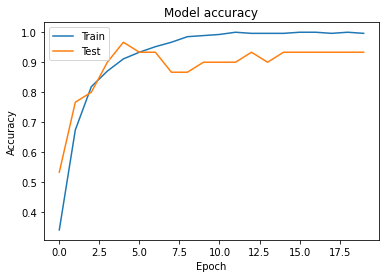

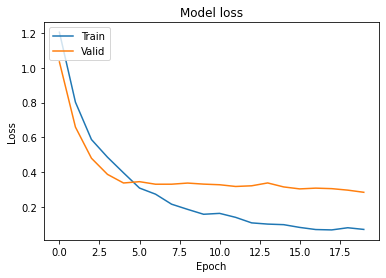

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#テスト実行

In [16]:
pred = model.predict(test_x)

print('先頭10個の結果')
pred[:10]

先頭10個の結果


array([[6.58851624e-01, 6.75623640e-02, 2.73586035e-01],
       [9.95357692e-01, 2.68679927e-03, 1.95548055e-03],
       [8.11439991e-01, 1.32699266e-01, 5.58607094e-02],
       [9.78564739e-01, 1.10188583e-02, 1.04164286e-02],
       [9.98414755e-01, 1.28563354e-03, 2.99620238e-04],
       [9.68271554e-01, 1.44850025e-02, 1.72434542e-02],
       [8.43513012e-01, 1.28272712e-01, 2.82143354e-02],
       [7.97630310e-01, 1.40750051e-01, 6.16196394e-02],
       [9.27559793e-01, 2.49361880e-02, 4.75040786e-02],
       [9.17049229e-01, 7.24594966e-02, 1.04912743e-02]], dtype=float32)

# 結果確認

In [17]:
# 予測結果
ans = tf.keras.backend.argmax(pred)
ans

<tf.Tensor: shape=(309,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 1,
       1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
     

In [18]:
test_x.shape

(309, 128, 128, 3)

In [19]:
# ラベル（正解）
test_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### 間違って予測したもの

In [20]:
ng_0, ng_1, ng_2 = [], [], []
for i in range(len(test_y)):
  if ans[i] != test_y[i]:
    if test_y[i] == 0:
      ng_0.append(i)
    elif test_y[i] == 1:
      ng_1.append(i)
    else:
      ng_2.append(i)

print('間違った個数')
print(f'{class_name_list[0]} : {len(ng_0)} / {sum(test_y == 0)}')
print(f'{class_name_list[1]} : {len(ng_1)} / {sum(test_y == 1)}')
print(f'{class_name_list[2]} : {len(ng_2)} / {sum(test_y == 2)}')


間違った個数
1_Shi-Tzu : 10 / 114
3_pug : 21 / 100
2_beagle : 15 / 95
